# Generate features (acoustic, phonetic, and lexical) for stimuli
## 0. Some basic functions
### 0.1. Test multicollinearity

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
import utils.group as gp
lme_dir = 'D:\\bsliang_Coganlabcode\\coganlab_ieeg\\projects\\lme\\data'

def check_multicollinearity(X_i,corr_labels):
    
    # Ensure the input is a NumPy array
    if not isinstance(X_i, np.ndarray):
        raise ValueError("Input X_i must be a NumPy array")

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = corr_labels
    vif_data["VIF"] = [variance_inflation_factor(X_i, i) for i in range(X_i.shape[1])]

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X_i, rowvar=False)  # Compute correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=corr_labels, yticklabels=corr_labels,annot_kws={"size": 5})
    plt.title("Feature Correlation Matrix")
    plt.show()

    return vif_data

### 0.2. PCA


In [4]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

def perform_pca_on_acoustic_features(envelope_feature_dict, original_feature_names,n_components=None, visualize=True, min_variance_retention=0.95):
    """
    Performs Principal Component Analysis (PCA) on a dictionary of acoustic features.

    Args:
        envelope_feature_dict (dict): A dictionary where keys are sample/word identifiers
                                      (e.g., 'bacon', 'bagel') and values are lists
                                      of their corresponding acoustic features (e.g., power envelope means
                                      across different frequency bands).
        n_components (int or float or None, optional): The number of components to keep after PCA.
            - If int: The exact number of principal components to return.
            - If float (0.0 < n_components < 1.0): The proportion of variance to explain.
              PCA will select the minimum number of components such that the explained variance
              is greater than or equal to this value.
            - If None (default): All components will be kept. The function will then
              suggest an optimal number based on `min_variance_retention`.
        visualize (bool, optional): If True, generate plots for explained variance and
                                     (if applicable) a scatter plot of the first two principal components.
                                     Defaults to True.
        min_variance_retention (float, optional): Only used if `n_components` is None.
            Specifies the minimum cumulative explained variance ratio (between 0 and 1)
            to retain for suggesting the number of components. Defaults to 0.95.

    Returns:
        tuple: A tuple containing:
            - pca_transformed_df (pd.DataFrame): DataFrame with the transformed principal components.
                                                Rows are samples, columns are principal components (PC1, PC2, ...).
            - pca_model (sklearn.decomposition.PCA): The fitted PCA model object.
            - scaler_model (sklearn.preprocessing.StandardScaler): The fitted StandardScaler model object.
    """

    print("--- Starting PCA Analysis ---")

    # 1. Convert the dictionary to a Pandas DataFrame
    # Each row will represent a sample (word), and each column will represent a feature (frequency band).
    df = pd.DataFrame.from_dict(envelope_feature_dict, orient='index')

    print(f"\nOriginal data shape: {df.shape} (samples x features)")
    # print("Original data (first 5 rows):\n", df.head()) # Uncomment for full data view

    # 2. Data Standardization
    # PCA is sensitive to feature scales, so standardization is a crucial step.
    # StandardScaler transforms data to have a mean of 0 and a standard deviation of 1.
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
    # print("\nScaled data (first 5 rows):\n", scaled_df.head()) # Uncomment for full data view

    # 3. Perform PCA (initial fit to get explained variance, if n_components is not directly specified)
    # If n_components is already specified, we'll directly use it.
    if n_components is None:
        pca = PCA() # Fit without specifying components to analyze explained variance
        pca.fit(scaled_data)
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)

        print("\nExplained variance per principal component:\n", explained_variance_ratio)
        print("\nCumulative explained variance:\n", cumulative_explained_variance)

        # Suggest optimal number of components based on min_variance_retention
        if len(cumulative_explained_variance) > 0:
            suggested_n_components = np.where(cumulative_explained_variance >= min_variance_retention)[0][0] + 1
            print(f"\nTo retain at least {min_variance_retention*100:.0f}% of the variance, "
                  f"it's suggested to select {suggested_n_components} principal components.")
            final_n_components = suggested_n_components
        else:
            final_n_components = 0
            print("No principal components could be determined from the data.")
    else:
        # If n_components is provided, use it directly
        final_n_components = n_components
        print(f"\nProceeding with PCA using n_components = {final_n_components}")

    # 4. Re-execute PCA with the determined or specified number of components
    if final_n_components > 0:
        pca_model = PCA(n_components=final_n_components)
        principal_components = pca_model.fit_transform(scaled_data)

        # Convert principal components to a DataFrame for easier handling
        pc_column_names = [f'PC{i+1}' for i in range(principal_components.shape[1])]
        pca_transformed_df = pd.DataFrame(data=principal_components, index=df.index, columns=pc_column_names)
        print(f"\nFinal PCA transformed data shape: {pca_transformed_df.shape}")
        print("PCA transformed data (first 5 rows):\n", pca_transformed_df.head())
    else:
        pca_transformed_df = pd.DataFrame(index=df.index) # Empty DataFrame if no components
        pca_model = None
        print("PCA could not be performed with the specified parameters or data.")
        
    # 5. Normolize results
    min_max_scaler = MinMaxScaler()
    # Apply Min-Max Scaling to the PCA transformed DataFrame
    normalized_pca_data = min_max_scaler.fit_transform(pca_transformed_df)
    normalized_pca_df = pd.DataFrame(normalized_pca_data,
                                     index=pca_transformed_df.index,
                                     columns=pca_transformed_df.columns)
    
    # 6. get loadings
    loadings_df = pd.DataFrame(pca_model.components_,
                               columns=original_feature_names,
                               index=pc_column_names)
    
    # 8. Visualization (Optional)
    if visualize and pca_model is not None:
        # Plot Explained Variance Ratio (if full PCA was done initially)
        if n_components is None and len(cumulative_explained_variance) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
            plt.axhline(y=min_variance_retention, color='r', linestyle=':', label=f'{min_variance_retention*100:.0f}% Variance')
            plt.axvline(x=final_n_components, color='g', linestyle=':', label=f'{final_n_components} Components')
            plt.title('PCA - Cumulative Explained Variance')
            plt.xlabel('Number of Principal Components')
            plt.ylabel('Cumulative Explained Variance Ratio')
            plt.xticks(range(1, len(explained_variance_ratio) + 1))
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Scatter plot of the first two principal components (if at least 2 components are kept)
        # if final_n_components >= 2:
        #     plt.figure(figsize=(8, 6))
        #     sns.scatterplot(x=pca_transformed_df.iloc[:, 0], y=pca_transformed_df.iloc[:, 1],
        #                     hue=pca_transformed_df.index, s=100, palette='viridis')
        #     plt.title('PCA - Scatter Plot of First Two Principal Components')
        #     plt.xlabel(f'Principal Component 1 (explains {pca_model.explained_variance_ratio_[0]*100:.2f}%)')
        #     plt.ylabel(f'Principal Component 2 (explains {pca_model.explained_variance_ratio_[1]*100:.2f}%)')
        #     plt.grid(True)
        #     # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #     plt.tight_layout()
        #     plt.show()
        # elif final_n_components == 1:
        #     print("\nOnly one principal component was retained. A 2D scatter plot is not applicable.")
        # --- New: Plotting Feature Loadings (Contributions) ---
        
        print("\n--- Visualizing Feature Loadings ---")
        # pca_model.components_ gives the principal axes in feature space (loadings)
        # It has shape (n_components, n_features)

        plt.figure(figsize=(12, 8))
        sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, linecolor='black')
        plt.title('Principal Component Loadings (Contribution of Original Features to PCs)')
        plt.xlabel('Original Features')
        plt.ylabel('Principal Components')
        plt.tight_layout()
        plt.show()

        # Optional: Bar plot for individual PC loadings (e.g., PC1)
        if final_n_components >= 1:
            for pc in ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']:
                plt.figure(figsize=(12, 6))
                loadings_df.loc[pc].plot(kind='bar')
                plt.title(f'Loadings of Original Features on Principal Component 1 {pc}')
                plt.xlabel('Original Features')
                plt.ylabel('Loading Value')
                plt.xticks(rotation=45, ha='right')
                plt.grid(axis='y', linestyle='--')
                plt.tight_layout()
                plt.show()
            
        print("\n--- Visualizing Clustered Feature Correlations ---")
        # Calculate the correlation matrix of the original (scaled) features
        plt.figure(figsize=(10, 8))
        # Use sns.clustermap which performs hierarchical clustering by default
        # The 'cbar_kws' argument helps to control the color bar label
        sns.clustermap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f",
                       linewidths=.5, figsize=(12, 10),
                       cbar_kws={'label': 'Correlation Coefficient'})
        plt.suptitle('Clustered Heatmap of Original Feature Correlations', y=1.02) # Adjusted title position
        plt.show()
            
    print("\n--- PCA Analysis Complete ---")
    return normalized_pca_df, pca_model, loadings_df

###Get lexical status

In [5]:
HOME = os.path.expanduser("~")
LAB_root = os.path.join(HOME, "Box", "CoganLab")

stats_root_delay = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "stats")
stats_root_nodelay = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepNoDelay', 'BIDS', "derivatives", "stats")

epoc_LexDelayRep_Aud,_=gp.load_stats('zscore','Auditory_inRep','epo',stats_root_delay,stats_root_delay,keeptrials=True,testsubj=True)

stim_lexsts = epoc_LexDelayRep_Aud.labels[0].split('/')[:,[3,2]]
del epoc_LexDelayRep_Aud
lexsts_dict = {str(item[0].split('-')[0]): str(item[1]) for item in stim_lexsts}
lexsts_bi_dict = {key: [1] if value == 'Word' else [0] for key, value in lexsts_dict.items()}
lexsts_bi_dict['magic']=[1]

Reading C:\Users\bl314\Box\CoganLab\BIDS-1.0_LexicalDecRepDelay\BIDS\derivatives\stats\D0024\Auditory_inRep_zscore-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -2500.00 ...    3990.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied


d:\bsliang_Coganlabcode\coganlab_ieeg\utils\group.py:65: UserWarning: The following subjects are not included: D0107 D0042
  warnings.warn(f"The following subjects are not included: D0107 D0042")


Reading C:\Users\bl314\Box\CoganLab\BIDS-1.0_LexicalDecRepDelay\BIDS\derivatives\stats\D0100\Auditory_inRep_zscore-epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    3990.00 ms
        0 CTF compensation matrices available
Not setting metadata
117 matching events found
No baseline correction applied


## 1. Phonemic feature matrix
### 1.1. Get MFA dictionary

In [6]:
def read_syllable_dict(file_path):
    """
    Reads a file and returns a dictionary with words as keys and phoneme lists as values.
    Ignores the numeric middle section between tabs, extracting only word and phonemes.
    
    Args:
        file_path (str): Path to the file
    
    Returns:
        dict: {word: [phonemes]}
    """
    syllable_dict = {}
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Remove leading/trailing whitespace and split by tabs
            parts = line.strip().split('\t')

            # Extract word (first part) and phonemes (third part)
            word = parts[0].replace("'", "")  # Remove single quotes if present
            if len(parts) == 6:
                phonemes_str = parts[5]  # Third part is the phonemes
            elif len(parts) == 2:
                phonemes_str = parts[1]  # Third part is the phonemes
            else:
                continue

            # Split phonemes by spaces into a list
            phonemes = phonemes_str.split()
            if not phonemes:  # If no phonemes found, skip the line
                print(f"No phonemes found in line: {line.strip()}")
                continue
                
            # Store in dictionary
            syllable_dict[word] = phonemes
    
    return syllable_dict

In [7]:
file_path = "english_us_lr.dict"
# Create the filename-to-phoneme dictionary
dict = read_syllable_dict(file_path)
for word, syllables in list(dict.items())[:10]:
    print(f"{word}: {syllables}")

d: ['D']
ll: ['L']
re: ['R', 'EY1']
s: ['EH1', 'S']
ve: ['V', 'IY1', 'IY1']
[bracketed]: ['spn']
<cutoff>: ['spn']
a: ['EY1']
as: ['EH1', 'Z']
abody: ['EY1', 'B', 'AA2', 'D', 'IY0']


### 1.2. Get the stimuli phonemic dictionary for the Lexical Delay Experiment

In [8]:
import os

def get_wav_files(directory):
    wav_files_names = {}
    wav_files = []
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return wav_files
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith('.wav'):  # Case-insensitive check for .wav files
            # Add to dictionary (key is filename, value can be None or customized)
            wav_files_names[filename[:-4]] = None
    return wav_files_names

In [9]:
def create_phoneme_start_time_dict(syllables, base_path:str='C:\\Users\\bl314\\Box\\CoganLab\\ECoG_Task_Data\\Stim\\Lexical\\mfa\\stim_annotations'):
    phoneme_start_times = {}
    for word in syllables.keys():
        print(f'getting timestamps of word {word}')
        file_path = os.path.join(base_path, f"{word}_phones.txt")
        try:
            with open(file_path, 'r') as f:
                start_times = []
                for i, line in enumerate(f):
                    if i < 5: 
                        parts = line.strip().split('\t')
                        if parts:
                            start_times.append(float(parts[0]))
                    else:
                        break
                phoneme_start_times[word] = start_times
        except FileNotFoundError:
            print(f"Not found {file_path}. Skipped {word}")
    return phoneme_start_times

In [10]:
directory = r"C:\Users\bl314\Box\CoganLab\task_stimuli\LexicalDecRepDelay"
syllables = get_wav_files(directory)
for syllable in syllables.keys():
    syllables[syllable] = dict.get(syllable)
    if syllable=='pilot' and len(syllables[syllable])<5:
        syllables[syllable].append('T')
    print(f"{syllable}: {syllables[syllable]}")
syllables_timestamps = create_phoneme_start_time_dict(syllables)
syllables_timestamps_DF=pd.DataFrame(syllables_timestamps)
print(syllables_timestamps_DF)
# Get time of the first phoneme
print(np.mean(syllables_timestamps_DF.iloc[1]))
print(np.std(syllables_timestamps_DF.iloc[1]))

print(np.mean(syllables_timestamps_DF.iloc[2]))
print(np.std(syllables_timestamps_DF.iloc[2]))

print(syllables.keys())


bacon: ['B', 'EY1', 'K', 'AH0', 'N']
bagel: ['B', 'EY1', 'G', 'AH0', 'L']
banel: ['B', 'AE1', 'N', 'AH0', 'L']
banic: ['B', 'AE1', 'N', 'IH0', 'K']
baron: ['B', 'AE1', 'R', 'AH0', 'N']
basin: ['B', 'EY1', 'S', 'AH0', 'N']
belet: ['B', 'EH1', 'L', 'EH0', 'T']
berin: ['B', 'AE1', 'R', 'IH0', 'N']
beris: ['B', 'AE1', 'R', 'IH0', 'S']
bison: ['B', 'AY1', 'S', 'AH0', 'N']
bonus: ['B', 'OW1', 'N', 'AH0', 'S']
boreb: ['B', 'AO1', 'R', 'AH0', 'B']
boril: ['B', 'AO1', 'R', 'AH0', 'L']
cabin: ['K', 'AE1', 'B', 'AH0', 'N']
camel: ['K', 'AE1', 'M', 'AH0', 'L']
caris: ['K', 'AE1', 'R', 'AH0', 'S']
casef: ['K', 'AA1', 'S', 'IH0', 'F']
cazel: ['K', 'AA1', 'Z', 'AH0', 'L']
civic: ['S', 'IH1', 'V', 'IH0', 'K']
civil: ['S', 'IH1', 'V', 'AH0', 'L']
cobin: ['K', 'AA1', 'B', 'IH0', 'N']
colon: ['K', 'OW1', 'L', 'AH0', 'N']
comet: ['K', 'AA1', 'M', 'AH0', 'T']
comic: ['K', 'AA1', 'M', 'IH0', 'K']
coral: ['K', 'AO1', 'R', 'AH0', 'L']
davel: ['D', 'EY1', 'V', 'AH0', 'L']
delin: ['D', 'EH1', 'L', 'IH0', 'N']
d

#### 1.2.2 Get phoneme proportions for word corpus

In [11]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

def split_dictionaries(syllables_dict, lexsts_dict):
    syllable_words = {}
    syllable_nonwords = {}
    
    for word, phonemes in syllables_dict.items():
        if word in lexsts_dict:
            if lexsts_dict[word] == [1]:
                syllable_words[word] = phonemes
            elif lexsts_dict[word] == [0]:
                syllable_nonwords[word] = phonemes
                
    return syllable_words, syllable_nonwords

def calculate_phoneme_proportions(phoneme_dict):
    if not phoneme_dict:
        return pd.DataFrame()

    max_len = max(len(p) for p in phoneme_dict.values())
    total_words = len(phoneme_dict)
    
    counts = [defaultdict(int) for _ in range(max_len)]
    
    for phoneme_list in phoneme_dict.values():
        for i, phoneme in enumerate(phoneme_list):
            counts[i][phoneme] += 1
            
    proportions_data = {}
    
    for i, pos_counts in enumerate(counts):
        position = i + 1
        proportions_data[position] = {
            phoneme: count / total_words 
            for phoneme, count in pos_counts.items()
        }

    df = pd.DataFrame(proportions_data).T.fillna(0)
    
    df.index.name = 'Position'
    df = df.reindex(sorted(df.index), axis=0)
    df = df.reindex(sorted(df.columns), axis=1)

    df = df.round(3) 

    return df

def calculate_similarity(df_words, df_nonwords):
    """
    Calculates the Cosine Similarity for the positional distribution 
    of each phoneme between the words and non-words dataframes.
    """
    # 1. Align the dataframes on all common phonemes
    common_phonemes = sorted(list(set(df_words.columns) & set(df_nonwords.columns)))
    
    if not common_phonemes:
        return pd.Series(dtype=float)

    # Reindex both dataframes to ensure they have the same positions (rows) 
    # and common phonemes (columns)
    all_positions = sorted(list(set(df_words.index) | set(df_nonwords.index)))
    
    # Extract phoneme distribution vectors, filling missing values with 0
    words_vectors = df_words.reindex(index=all_positions, columns=common_phonemes).fillna(0)
    nonwords_vectors = df_nonwords.reindex(index=all_positions, columns=common_phonemes).fillna(0)

    similarity_results = {}

    for phoneme in common_phonemes:
        # P is the distribution vector for the phoneme in words across all positions
        P = words_vectors[phoneme].values.reshape(1, -1)
        # Q is the distribution vector for the phoneme in non-words across all positions
        Q = nonwords_vectors[phoneme].values.reshape(1, -1)
        
        # Calculate Cosine Similarity. 
        # If either P or Q is a zero-vector (phoneme never appears in one set), 
        # we can skip or handle as 0 similarity (no shared direction).
        # We check for a non-zero vector before calculating similarity.
        if np.linalg.norm(P) == 0 or np.linalg.norm(Q) == 0:
            similarity = 0.0
        else:
            similarity = cosine_similarity(P, Q)[0][0]
        
        similarity_results[phoneme] = similarity

    # Convert to a Series, sort by similarity (high to low), and round
    results_series = pd.Series(similarity_results).sort_values(ascending=False).round(4)
    return results_series


In [12]:
# In the past we tried split word and nonword. But we don't have to now.
syllable_words, syllable_nonwords = split_dictionaries(syllables, lexsts_bi_dict)

print("--- Phoneme Proportions Table for Words (syllable_words) ---")
print(f"Total Words: {len(syllable_words)}")
df_words = calculate_phoneme_proportions(syllable_words)
print(df_words)

print("\n" + "="*50 + "\n")

print("--- Phoneme Proportions Table for Non-Words (syllable_nonwords) ---")
print(f"Total Non-Words: {len(syllable_nonwords)}")
df_nonwords = calculate_phoneme_proportions(syllable_nonwords)
print(df_nonwords)

similarity_scores = calculate_similarity(df_words, df_nonwords)
print(similarity_scores)

--- Phoneme Proportions Table for Words (syllable_words) ---
Total Words: 62
            AA0    AA1   AE1    AE2    AH0    AY1      B      D    EH1    EY1  \
Position                                                                        
1         0.000  0.000  0.00  0.000  0.000  0.000  0.048  0.016  0.000  0.000   
2         0.000  0.097  0.21  0.000  0.000  0.097  0.000  0.000  0.177  0.129   
3         0.000  0.000  0.00  0.000  0.000  0.000  0.065  0.048  0.000  0.000   
4         0.016  0.000  0.00  0.016  0.806  0.000  0.000  0.000  0.000  0.000   
5         0.000  0.000  0.00  0.000  0.000  0.000  0.000  0.065  0.000  0.000   

          ...      M      N    OW1      P      R      S      T    UW1      V  \
Position  ...                                                                  
1         ...  0.161  0.032  0.000  0.113  0.081  0.145  0.113  0.000  0.065   
2         ...  0.000  0.000  0.145  0.000  0.000  0.000  0.000  0.016  0.000   
3         ...  0.065  0.177  0.000 

In [17]:
# Do phoneme comparison for words and nonwords

print(syllable_words)
print(syllable_nonwords)
import pandas as pd
from collections import Counter
from scipy.stats import chi2_contingency

# 1. Count phoneme frequencies for words and nonwords
word_phonemes = [phoneme for word in syllable_words.values() for phoneme in word]
nonword_phonemes = [phoneme for word in syllable_nonwords.values() for phoneme in word]

word_counts = Counter(word_phonemes)
nonword_counts = Counter(nonword_phonemes)

# 2. Create a DataFrame for display
all_phonemes = sorted(list(set(word_counts.keys()) | set(nonword_counts.keys())))
freq_df = pd.DataFrame(index=all_phonemes, columns=['Word Frequency', 'Non-word Frequency'])

for phoneme in all_phonemes:
    freq_df.loc[phoneme, 'Word Frequency'] = word_counts.get(phoneme, 0)
    freq_df.loc[phoneme, 'Non-word Frequency'] = nonword_counts.get(phoneme, 0)

print("Phoneme Frequencies:\n")
print(freq_df)

# 3. Perform Chi-squared test
# The contingency table for the chi-squared test will have phonemes as rows
# and word type (word/non-word) as columns.
contingency_table = freq_df.to_numpy().astype(int) # <-- FIX: Cast to a numeric dtype

# Now, the test will run without errors.

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n--- Chi-squared Test Results ---")
print(f"Chi-squared statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")

alpha = 0.05
print(f"\nSignificance level (alpha): {alpha}")
if p < alpha:
    print("The p-value is less than the significance level.")
    print("We reject the null hypothesis: there is a significant difference in phoneme distributions between words and non-words.")
else:
    print("The p-value is not less than the significance level.")
    print("We fail to reject the null hypothesis: there is no significant difference in phoneme distributions between words and non-words.")



{'bacon': ['B', 'EY1', 'K', 'AH0', 'N'], 'baron': ['B', 'AE1', 'R', 'AH0', 'N'], 'bison': ['B', 'AY1', 'S', 'AH0', 'N'], 'cabin': ['K', 'AE1', 'B', 'AH0', 'N'], 'civic': ['S', 'IH1', 'V', 'IH0', 'K'], 'civil': ['S', 'IH1', 'V', 'AH0', 'L'], 'colon': ['K', 'OW1', 'L', 'AH0', 'N'], 'comet': ['K', 'AA1', 'M', 'AH0', 'T'], 'comic': ['K', 'AA1', 'M', 'IH0', 'K'], 'demon': ['D', 'IY1', 'M', 'AH0', 'N'], 'facet': ['F', 'AE1', 'S', 'AH0', 'T'], 'fatal': ['F', 'EY1', 'T', 'AH0', 'L'], 'feral': ['F', 'EH1', 'R', 'AH0', 'L'], 'focal': ['F', 'OW1', 'K', 'AH0', 'L'], 'haven': ['HH', 'EY1', 'V', 'AH0', 'N'], 'hazel': ['HH', 'EY1', 'Z', 'AH0', 'L'], 'latin': ['L', 'AE1', 'T', 'AH0', 'N'], 'level': ['L', 'EH1', 'V', 'AH0', 'L'], 'libel': ['L', 'AY1', 'B', 'AH0', 'L'], 'linen': ['L', 'IH1', 'N', 'AH0', 'N'], 'madam': ['M', 'AE1', 'D', 'AH0', 'M'], 'magic': ['M', 'AE1', 'JH', 'IH0', 'K'], 'manic': ['M', 'AE1', 'N', 'IH0', 'K'], 'mason': ['M', 'EY1', 'S', 'AH0', 'N'], 'melon': ['M', 'EH1', 'L', 'AH0', 'N

In [ ]:
print("--- Phoneme (Selected) Proportions Table for Words ---")
print(df_words[['AA1', 'AE1', 'AH0', 'EY1', 'EH1', 'IH0']])
print("                 ")
print("--- Phoneme (Selected) Proportions Table for Nonwords ---")
print(df_nonwords[['AA1', 'AE1', 'AH0', 'EY1', 'EH1', 'IH0']])

In [25]:
#For LME: save phoneme categories and timestamps for each syllable
import pickle
filename = os.path.join(lme_dir,'stim_pho_dict.pkl')
with open(filename, 'wb') as f:
    pickle.dump(syllables, f)
filename = os.path.join(lme_dir,'stim_pho_t_dict.pkl')
with open(filename, 'wb') as f:
    pickle.dump(syllables_timestamps, f)


In [35]:
df_words = calculate_phoneme_proportions(syllables)
THRESHOLD = 0.1
columns_to_keep = (df_words > THRESHOLD).any(axis=0)
filtered_df = df_words.loc[:, columns_to_keep]
resulting_column_names = filtered_df.columns.tolist()
print(resulting_column_names)

['AA1', 'AE1', 'AH0', 'AO1', 'EH0', 'EH1', 'EY1', 'IH0', 'K', 'L', 'M', 'N', 'R', 'T', 'V']


In [36]:
print("--- Phoneme (Selected) Proportions Table for Words ---")
print(df_words[['K', 'L', 'M', 'N', 'R', 'T', 'V']])
print(df_words[['AA1', 'AE1', 'AH0', 'AO1', 'EH0', 'EH1', 'EY1', 'IH0']])
print("                 ")

--- Phoneme (Selected) Proportions Table for Words ---
              K      L      M      N      R      T      V
Position                                                 
1         0.071  0.095  0.125  0.054  0.060  0.107  0.060
2         0.000  0.000  0.000  0.000  0.000  0.000  0.000
3         0.054  0.155  0.071  0.161  0.155  0.054  0.125
4         0.000  0.000  0.006  0.000  0.000  0.000  0.000
5         0.143  0.310  0.077  0.208  0.006  0.071  0.000
            AA1    AE1    AH0    AO1    EH0    EH1    EY1    IH0
Position                                                        
1         0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2         0.107  0.226  0.000  0.113  0.000  0.179  0.113  0.000
3         0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
4         0.000  0.000  0.536  0.000  0.107  0.000  0.000  0.327
5         0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
                 


### 1.3. (!!!!! OLD VERSION: get all phonemes) One-hot encoding for each unique phoneme

In [67]:
# Get unique phoneme vector
all_phonemes = set()
for phonemes in syllables.values():
    all_phonemes.update(phonemes)
all_phonemes = sorted(list(all_phonemes))  # Sort for consistent ordering
phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(all_phonemes)}
vector_length = len(all_phonemes)
print(len(all_phonemes))

# Create one-hot encoding for each word
phoneme_one_hot_dict = {}
for word, phonemes in syllables.items():
    # Initialize vector with zeros
    vector = [0] * vector_length
    # Set 1 for each phoneme present in the word
    for phoneme in phonemes:
        vector[phoneme_to_index[phoneme]] = 1
    phoneme_one_hot_dict[word] = vector

37


###  (!!!!! OLD VERSION: get all phonemes)

C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


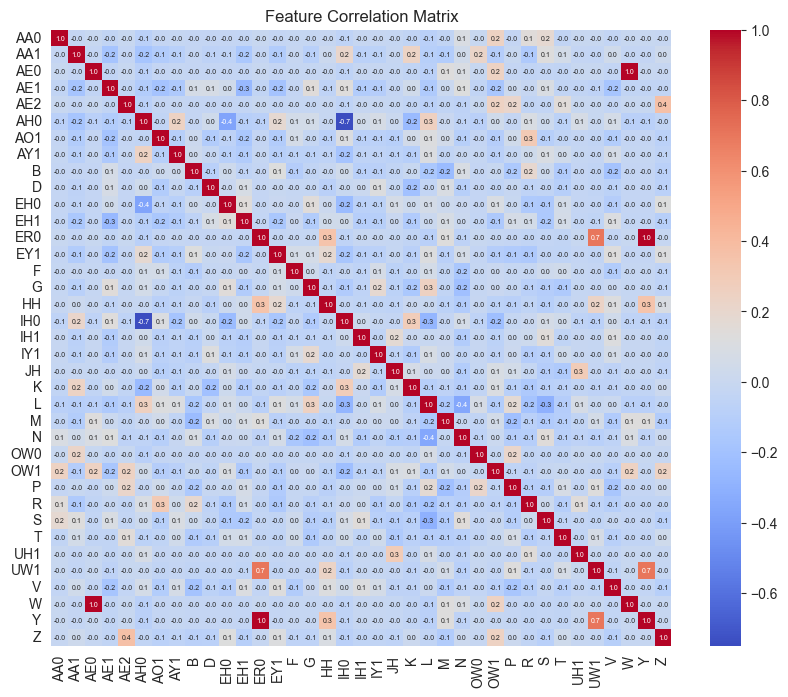

fatal: ['F', 'EY1', 'T', 'AH0', 'L'] contains T, L and AH0
fetal: ['F', 'IY1', 'T', 'AH0', 'L'] contains T, L and AH0
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains ER0
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains Y
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains UW1
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains both HH and M
latin: ['L', 'AE1', 'T', 'AH0', 'N'] contains T, L and AH0
metal: ['M', 'EH1', 'T', 'AH0', 'L'] contains T, L and AH0
natal: ['N', 'EY1', 'T', 'AH0', 'L'] contains T, L and AH0
petal: ['P', 'EH1', 'T', 'AH0', 'L'] contains T, L and AH0
pilot: ['P', 'AY1', 'L', 'AH0', 'T'] contains T, L and AH0
roman: ['R', 'OW1', 'M', 'AH0', 'N'] contains OW1, M and N
tidal: ['T', 'AY1', 'D', 'AH0', 'L'] contains T, L and AH0
torel: ['T', 'AO1', 'R', 'AH0', 'L'] contains T, L and AH0
tulip: ['T', 'UW1', 'L', 'AH0', 'P'] contains UW1
tulip: ['T', 'UW1', 'L', 'AH0', 'P'] contains T, L and AH0
vital: ['V', 'AY1', 'T', 'AH0', 'L'] contains T, L and AH0
woman: ['W', 'OW1', 'M', 'AE0'

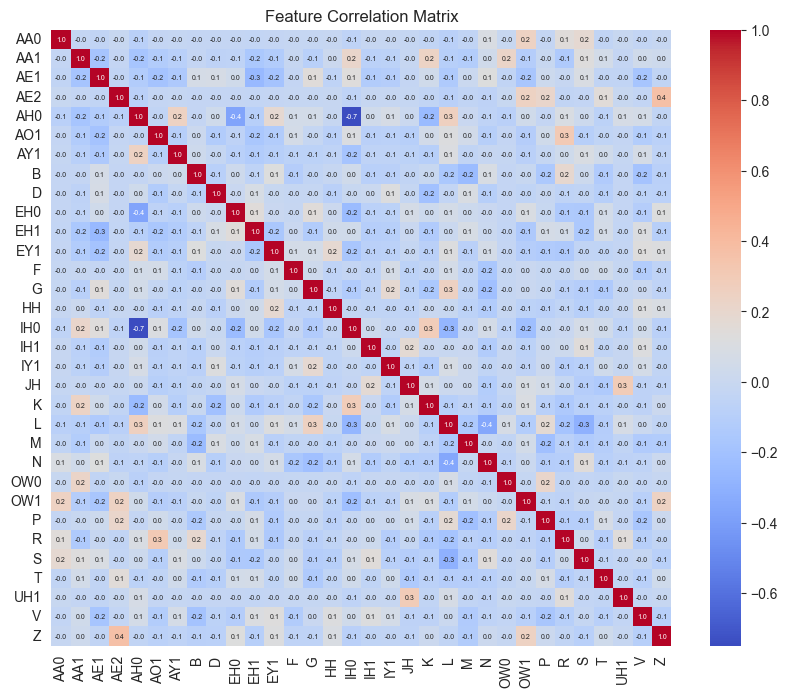

,Feature,VIF
0,AA0,1.801116
1,AA1,12.215277
2,AE1,24.399500
3,AE2,2.104249
4,AH0,63.865997
5,AO1,12.844235
6,AY1,7.562020
7,B,2.592075
8,D,2.043709
9,EH0,13.836986


In [68]:
# Check the multicolinearity and reduce the feature dimensions
check_multicollinearity(np.array(list(phoneme_one_hot_dict.values())),all_phonemes)
# Print the words tha contain AE0, W, ER0, and Y
for syllable, value in syllables.items():
    if value and "AE0" in value:
        print(f"{syllable}: {value} contains AE0")
    if value and "W" in value:
        print(f"{syllable}: {value} contains W")
    if value and "ER0" in value:
        print(f"{syllable}: {value} contains ER0")
    if value and "Y" in value:
        print(f"{syllable}: {value} contains Y")
    if value and "UW1" in value:
        print(f"{syllable}: {value} contains UW1")
    if value and "HH" in value and "M" in value:
        print(f"{syllable}: {value} contains both HH and M")
    if value and "T" in value and "L" in value and "AH0" in value:
        print(f"{syllable}: {value} contains T, L and AH0")
    if value and "OW1" in value and "M" in value and "N" in value:
        print(f"{syllable}: {value} contains OW1, M and N")
# I think it is safe to reduce ER0, Y, UW1, AE0, and W
# Then: humor - HH and M, tulip - 'T', 'L', 'AH0', 'P', women - 'OW1', 'M', 'N'

# reduce the dimensions:
indices_to_remove=[all_phonemes.index("ER0"),all_phonemes.index("Y"),all_phonemes.index("UW1"),all_phonemes.index("AE0"),all_phonemes.index("W")]
phoneme_one_hot_dict_filt = {key: vec for key, vec in phoneme_one_hot_dict.items()}
for i, (key, vec) in enumerate(phoneme_one_hot_dict.items()):
    # Create a copy of the vector with specified indices removed
    filtered_vec = np.delete(vec, indices_to_remove)
    phoneme_one_hot_dict_filt[key] = filtered_vec
all_phonemes_filt = []
all_phonemes_filt = [p for i, p in enumerate(all_phonemes) if i not in indices_to_remove]

# Check the multicolinearity again
check_multicollinearity(np.array(list(phoneme_one_hot_dict_filt.values())),all_phonemes_filt)

### 1.3 (!!! NEW VERSION: only combine word and nonword)

{'AA1': 0, 'AE1': 1, 'AH0': 2, 'AO1': 3, 'EH0': 4, 'EH1': 5, 'EY1': 6, 'IH0': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'R': 12, 'T': 13, 'V': 14}


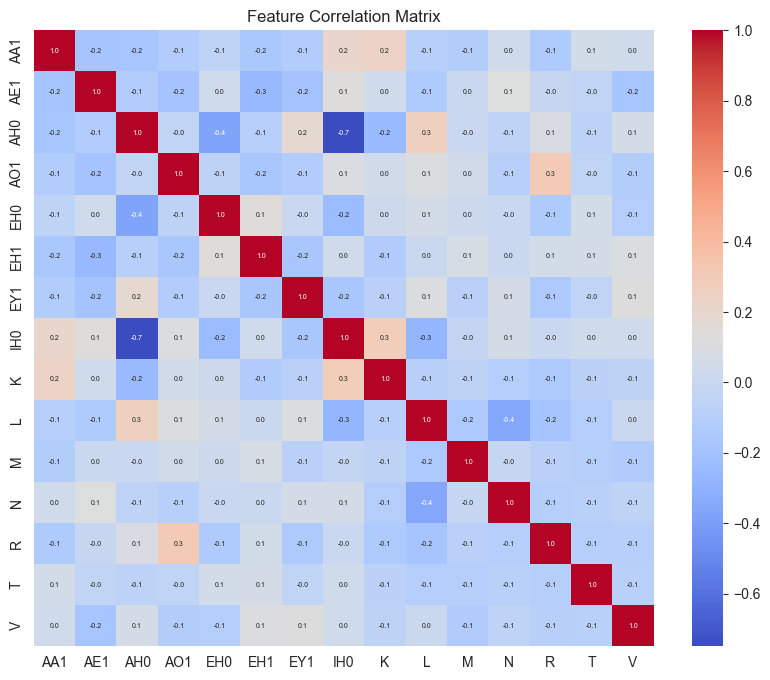

In [37]:

# R
# When combine words and nonwords, and removed all the small contributors (proportions < 0.05)
# all_phonemes = ['AA1', 'AE1', 'AH0', 'EY1', 'EH1', 'IH0']

# When just remove all the small contributors but not separate words and nonwords
all_phonemes=['AA1', 'AE1', 'AH0', 'AO1', 'EH0', 'EH1', 'EY1', 'IH0','K', 'L', 'M', 'N', 'R', 'T', 'V']
# vowels
# all_phonemes=['AA1', 'AE1', 'AH0', 'AO1', 'EH0', 'EH1', 'EY1', 'IH0']
# consonants
# all_phonemes=['K', 'L', 'M', 'N', 'R', 'T', 'V']
all_phonemes = sorted(list(all_phonemes))  # Sort for consistent ordering
phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(all_phonemes)}
vector_length = len(all_phonemes)
print(phoneme_to_index)
# Create one-hot encoding for each word
phoneme_one_hot_dict = {}
for word, phonemes in syllables.items():
    # Initialize vector with zeros
    vector = [0] * vector_length
    # Set 1 for each phoneme present in the word
    for phoneme in phonemes:
        if phoneme in all_phonemes:
            vector[phoneme_to_index[phoneme]] = 1
    phoneme_one_hot_dict[word] = vector
check_multicollinearity(np.array(list(phoneme_one_hot_dict.values())),all_phonemes)
phoneme_one_hot_dict_filt=phoneme_one_hot_dict
all_phonemes_filt=all_phonemes


--- Running PCA with automatic component selection (95% variance) ---
--- Starting PCA Analysis ---

Original data shape: (168, 15) (samples x features)

Explained variance per principal component:
 [0.15383961 0.10541931 0.10030948 0.0947073  0.08885987 0.07410751
 0.06913987 0.06781576 0.06124718 0.05156346 0.04827791 0.04388188
 0.02207656 0.01577043 0.00298387]

Cumulative explained variance:
 [0.15383961 0.25925891 0.35956839 0.4542757  0.54313557 0.61724307
 0.68638294 0.7541987  0.81544588 0.86700935 0.91528726 0.95916914
 0.98124569 0.99701613 1.        ]

To retain at least 90% of the variance, it's suggested to select 11 principal components.

Final PCA transformed data shape: (168, 11)
PCA transformed data (first 5 rows):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
bacon  0.715674 -1.294090 -0.062954 -2.051102 -0.107935 -0.740720 -0.150387   
bagel  2.372710 -1.080315 -0.679261 -0.672440 -0.629975 -0.386778 -0.607976   
banel  0.897272 -0

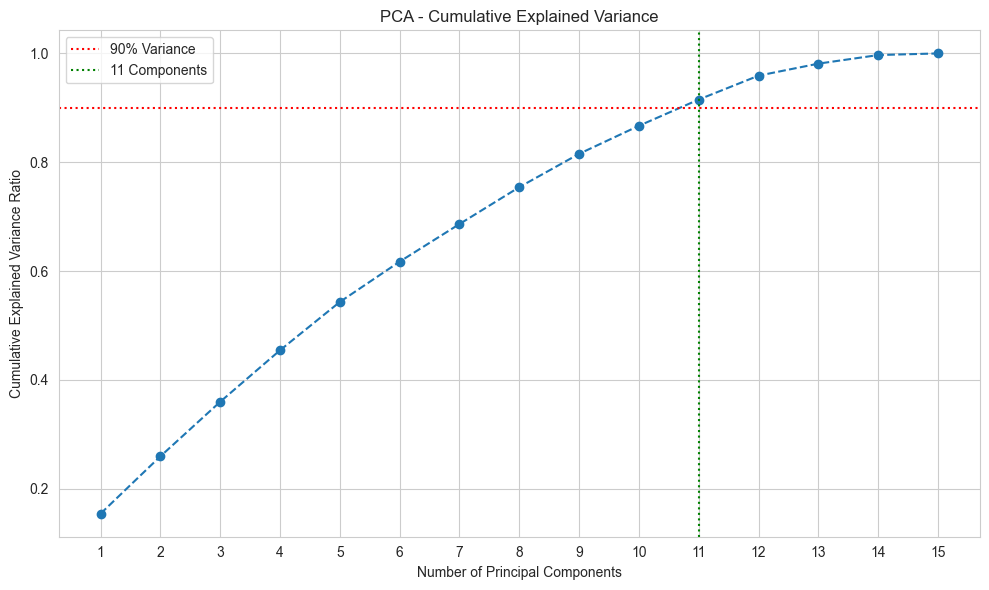


--- Visualizing Feature Loadings ---


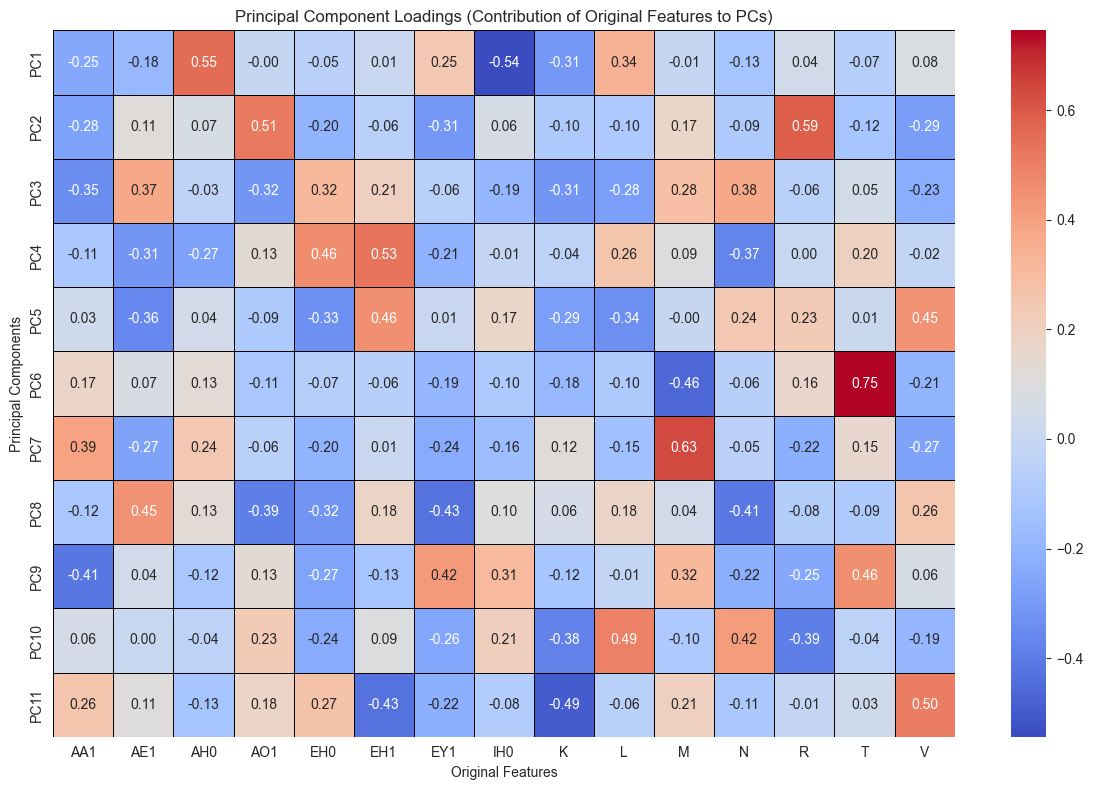

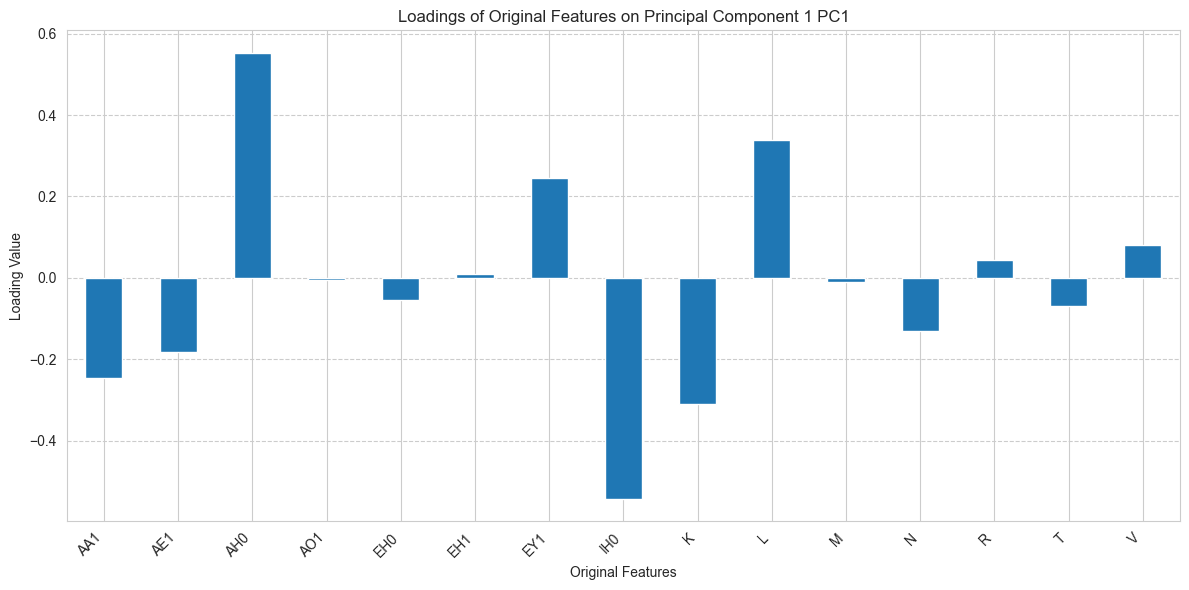

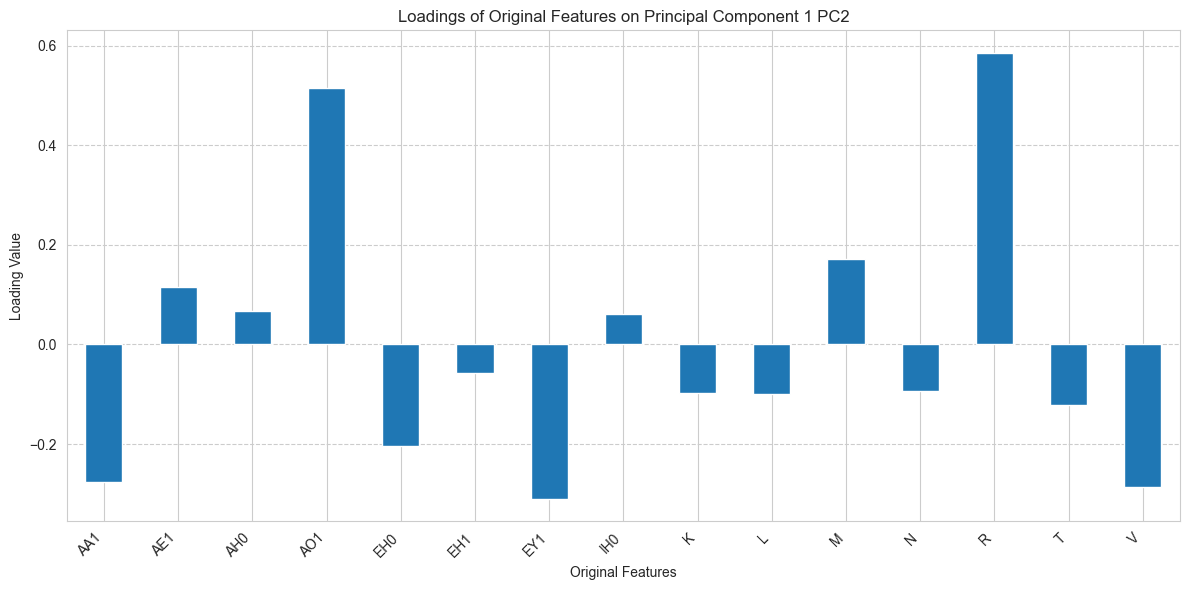

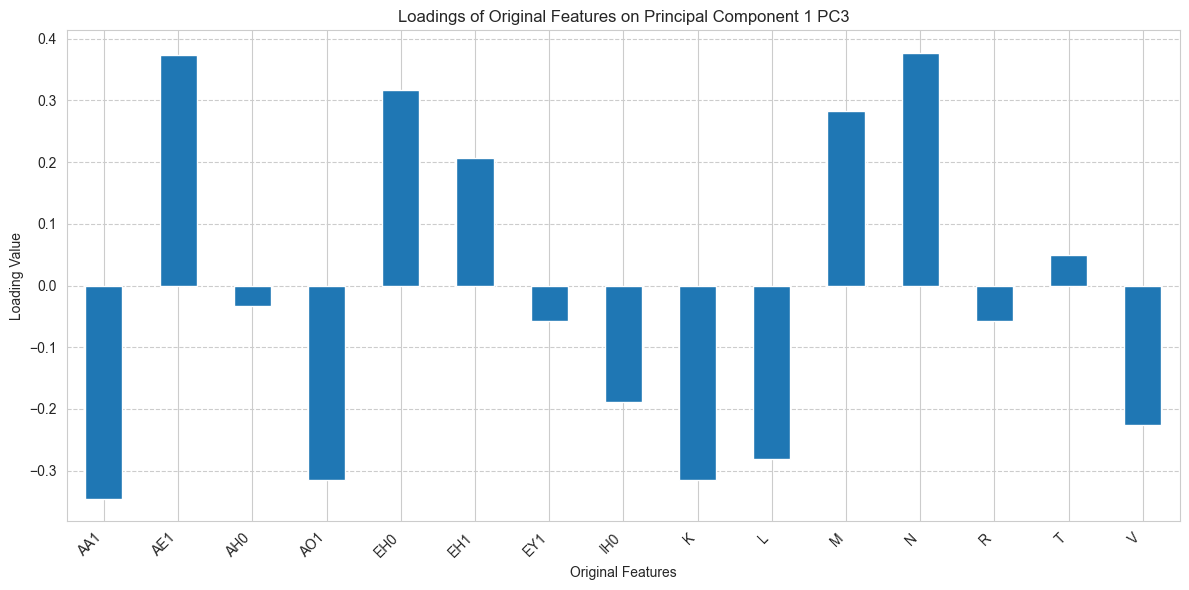

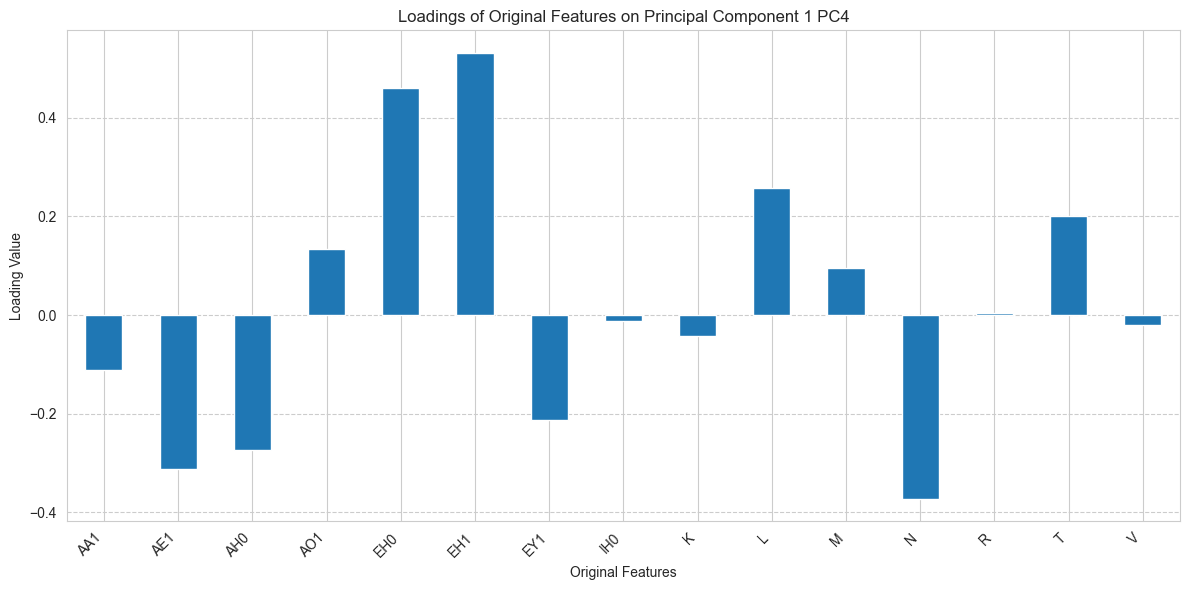

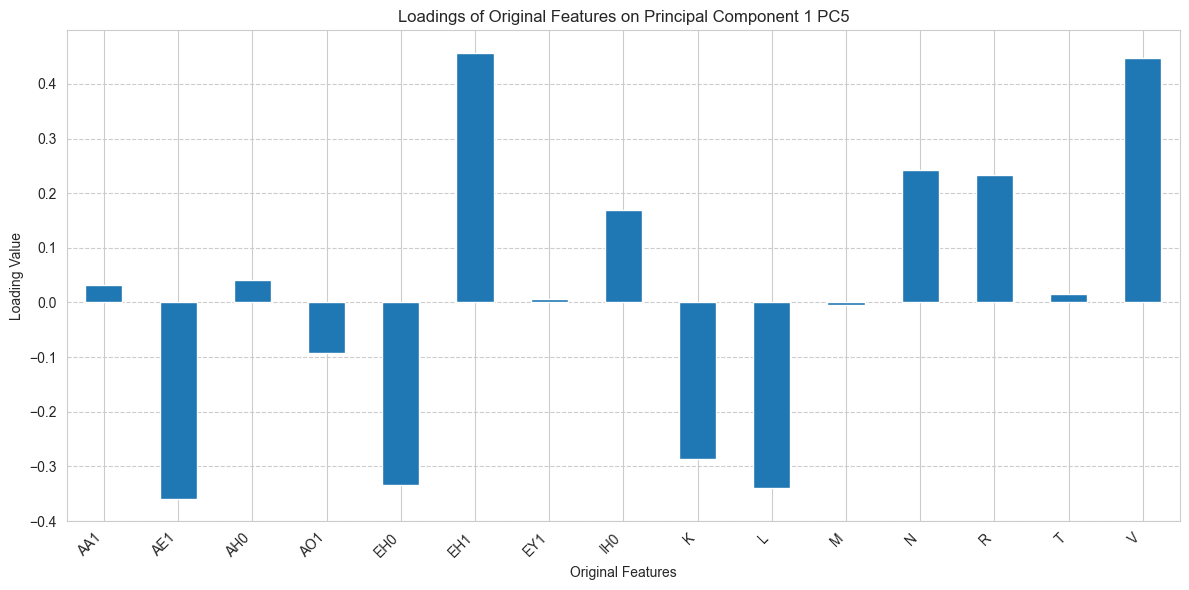


--- Visualizing Clustered Feature Correlations ---


<Figure size 1000x800 with 0 Axes>

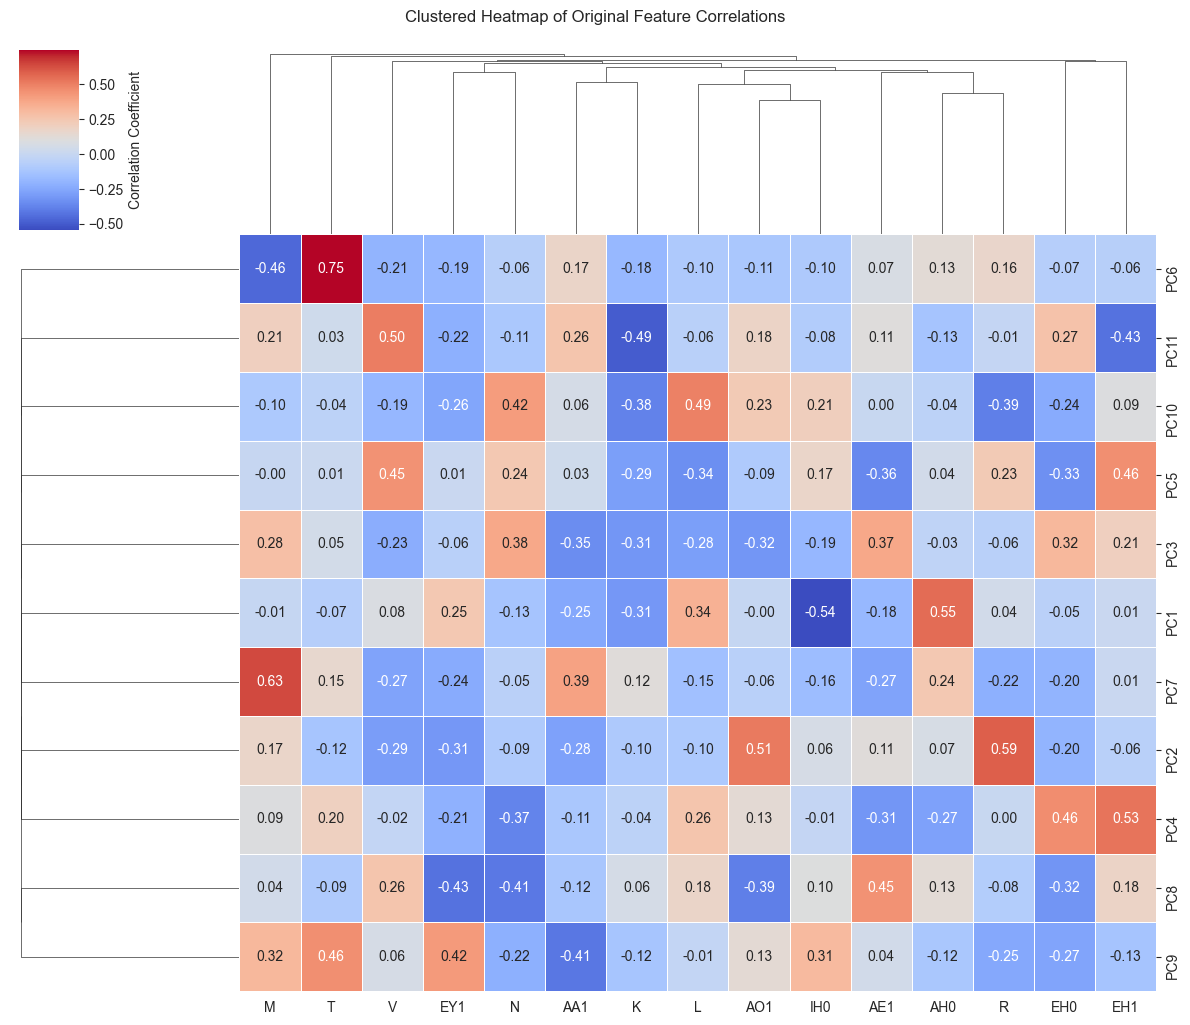


--- PCA Analysis Complete ---
bacon : [0.6822322951359752, 0.17060721649170965, 0.5016172168031626, 0.012437491587081184, 0.44046076500431464, 0.30126362535615187, 0.27780261912143034, 0.19227626804713127, 0.550479500328218, 0.2682655343650597, 0.06427208322094774]
bagel : [0.9640519521253411, 0.20736782570156684, 0.40500400682929927, 0.2406688728870675, 0.35384618206206064, 0.3801509757117239, 0.19432251642162476, 0.4094897094182492, 0.6784879529270271, 0.48238261580180203, 0.34899985056167576]
banel : [0.7131174656423674, 0.3897894948920704, 0.6947751237679829, 0.10195297159404587, 0.2901183513856352, 0.5217951113309133, 0.1940731155441831, 0.7350011874562035, 0.37101331746494814, 0.8374311367920931, 0.5183575822928941]
banic : [0.0911365838439997, 0.38559978292931973, 0.6176624986937937, 0.08665715693733578, 0.3402046232640191, 0.36839797443456407, 0.14450092643392037, 0.6793939343894831, 0.488770602537633, 0.556670787514838, 0.3032341021697418]


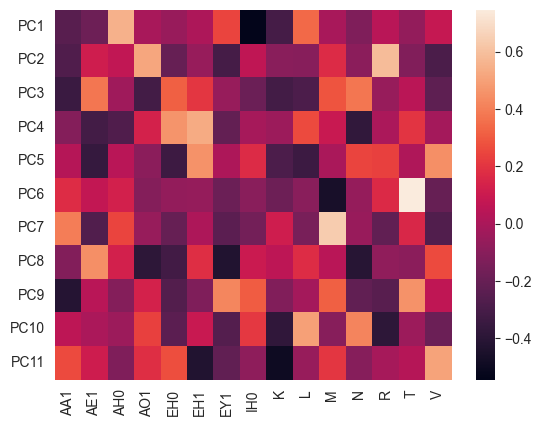

In [38]:
# PCA
print("\n--- Running PCA with automatic component selection (95% variance) ---")
pca_results_auto, _, loadings_df = perform_pca_on_acoustic_features(
    phoneme_one_hot_dict_filt,original_feature_names=all_phonemes_filt,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
phoneme_one_hot_dict_filt_pca = pca_results_auto.to_dict('index')
phoneme_one_hot_dict_filt_pca = {key: list(value.values()) for key, value in phoneme_one_hot_dict_filt_pca.items()}
sns.heatmap(loadings_df)

for key, values in list(phoneme_one_hot_dict_filt_pca.items())[:4]:  # Show first 5 entries
    print(key, ":", values)


In [69]:
# save the phoneme_one_hot_dicphoneme_one_hot_dictt
import pickle
phoneme_one_hot_dict_path = "phoneme_one_hot_dict.pickle"
with open(phoneme_one_hot_dict_path, 'wb') as handle:
    pickle.dump(phoneme_one_hot_dict_filt, handle)
phoneme_one_hot_dict_filt

{'bacon': array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'bagel': array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'banel': array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'banic': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'baron': array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'basin': array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'belet': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'berin': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'beris': array(

In [70]:
range(all_phonemes_filt)

TypeError: 'list' object cannot be interpreted as an integer

In [72]:
import pandas as pd
phoneme_one_hot_dict_filt_df = pd.DataFrame(phoneme_one_hot_dict_filt)
phoneme_one_hot_dict_filt_df.index = [f"pho{i+1}" for i in range(len(all_phonemes_filt))]
phoneme_one_hot_dict_filt_df.to_csv(os.path.join(lme_dir,'phoneme_one_hot_dict.csv'), index=True)
phoneme_one_hot_dict_filt_pca_df = pd.DataFrame(phoneme_one_hot_dict_filt_pca)
num_rows = phoneme_one_hot_dict_filt_pca_df.shape[0]
phoneme_one_hot_dict_filt_pca_df.index = [f"pho{i+1}" for i in range(num_rows)]
print(phoneme_one_hot_dict_filt_pca_df)
phoneme_one_hot_dict_filt_pca_df.to_csv(os.path.join(lme_dir,'phoneme_one_hot_dict_pca.csv'), index=True)

          bacon     bagel     banel     banic     baron     basin     belet  \
pho1   0.682232  0.964052  0.713117  0.091137  0.615372  0.803170  0.589171   
pho2   0.170607  0.207368  0.389789  0.385600  0.667391  0.208873  0.163571   
pho3   0.501617  0.405004  0.694775  0.617662  0.761431  0.614573  0.708207   
pho4   0.012437  0.240669  0.101953  0.086657  0.018110  0.028763  1.000000   
pho5   0.440461  0.353846  0.290118  0.340205  0.496351  0.549000  0.360976   
pho6   0.301264  0.380151  0.521795  0.368398  0.653305  0.394817  0.772587   
pho7   0.277803  0.194323  0.194073  0.144501  0.152151  0.229530  0.194083   
pho8   0.192276  0.409490  0.735001  0.679394  0.625176  0.165494  0.472668   
pho9   0.550480  0.678488  0.371013  0.488771  0.266719  0.601350  0.461087   
pho10  0.268266  0.482383  0.837431  0.556671  0.429042  0.453117  0.538965   
pho11  0.064272  0.349000  0.518358  0.303234  0.537149  0.324340  0.526052   

          berin     beris     bison  ...     vanic 

In [ ]:
# # Read the saved one hot dict. Just for demonstration
# import pandas as pd
# d= pd.read_pickle("phoneme_one_hot_dict.pickle")

## 2. Acoustic feature (Power envelope at five frequency bins)
### 2.1. Read normolized binned envelope 
(The matrix was generated by `get_stims_envelope.m`)

In [18]:
envelope_feature_dict = {}

with open("envelope_power_bins.txt", "r") as file:
    for line in file:
        parts = line.strip().split("\t")
        key = parts[0]
        values = list(map(float, parts[1:]))  # Convert remaining columns to float
        envelope_feature_dict[key] = values
feature_names=['50.00 Hz','120.58 Hz','209.04 Hz','319.88 Hz','458.78 Hz','632.84 Hz','850.96 Hz','1124.30 Hz','1466.84 Hz','1896.08 Hz','2433.98 Hz','3108.04 Hz','3952.74 Hz','5011.26 Hz','6337.74 Hz','8000.00 Hz']
# Print a sample of the dictionary
for key, values in list(envelope_feature_dict.items())[:5]:  # Show first 5 entries
    print(key, ":", values)
import pandas as pd

bacon : [0.296571, 0.679119, 0.654061, 0.912844, 0.623807, 0.648764, 0.137363, 0.029119, 0.015504, 0.062601, 0.641239, 0.716769, 0.487837, 0.308751, 0.148496, 0.014086]
bagel : [0.294559, 0.562094, 0.63364, 0.886278, 0.650092, 0.561301, 0.208617, 0.234761, 0.049883, 0.016795, 0.518351, 0.811275, 0.528009, 0.38513, 0.077717, 0.011942]
banel : [0.433478, 0.696933, 0.69218, 0.575856, 0.439453, 0.899617, 0.678323, 0.355078, 0.158576, 0.440505, 0.735245, 0.818001, 0.541304, 0.442179, 0.399292, 0.02589]
banic : [0.310589, 0.598114, 0.659623, 0.499222, 0.495335, 0.974619, 0.717401, 0.193477, 0.061496, 0.275164, 0.806595, 0.721089, 0.349668, 0.467902, 0.37589, 0.013435]
baron : [0.278518, 0.606174, 0.331545, 0.685306, 0.199569, 0.58373, 0.785836, 0.319984, 0.170117, 0.612108, 0.666829, 0.430677, 0.419611, 0.313882, 0.212093, 0.010565]


In [28]:
# See whether words and nonwords are different acoustically
directory = r"C:\Users\bl314\Box\CoganLab\task_stimuli\LexicalDecRepDelay"
syllables_aco = get_wav_files(directory)
for syllable in syllables_aco.keys():
    syllables_aco[syllable] = envelope_feature_dict.get(syllable)
syllables_aco_words, syllables_aco_nonwords = split_dictionaries(syllables_aco, lexsts_bi_dict)
print(syllables_aco_nonwords)
print(syllables_aco_words)

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


# 1. Convert dictionaries to pandas DataFrames for easier handling
words_df = pd.DataFrame.from_dict(syllables_aco_words, orient='index')
nonwords_df = pd.DataFrame.from_dict(syllables_aco_nonwords, orient='index')

# Rename columns for clarity
words_df.columns = [f'Position_{i+1}' for i in range(16)]
nonwords_df.columns = [f'Position_{i+1}' for i in range(16)]

# 2. Perform t-test for each position
results = []
for i in range(16):
    position_col = f'Position_{i+1}'
    
    # Get the data for the current position for both groups
    word_values = words_df[position_col]
    nonword_values = nonwords_df[position_col]
    
    # Perform independent samples t-test
    t_stat, p_value = ttest_ind(word_values, nonword_values, nan_policy='omit')
    
    results.append({
        'Position': i + 1,
        'T-statistic': t_stat,
        'P-value': p_value
    })

# 3. Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# 4. Apply FDR correction for multiple comparisons
alpha = 0.05
p_values = results_df['P-value']
reject, p_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Add corrected results to the DataFrame
results_df['P-value (FDR corrected)'] = p_corrected
results_df['Significant (uncorrected)'] = results_df['P-value'] < alpha
results_df['Significant (FDR corrected)'] = reject


# 5. Display and interpret the final results
print("T-test Results for Each Position (Words vs. Nonwords) with FDR Correction:\n")
print(results_df.to_string())

print(f"\n--- Interpretation (at alpha = {alpha}) ---\n")
significant_positions = results_df[results_df['Significant (FDR corrected)']]

if not significant_positions.empty:
    print("After FDR correction, a significant difference was found at the following positions:")
    for pos in significant_positions['Position']:
        print(f"- Position {pos}")
else:
    print("After FDR correction, no significant difference was found at any of the 16 positions.")

{'banel': [0.433478, 0.696933, 0.69218, 0.575856, 0.439453, 0.899617, 0.678323, 0.355078, 0.158576, 0.440505, 0.735245, 0.818001, 0.541304, 0.442179, 0.399292, 0.02589], 'banic': [0.310589, 0.598114, 0.659623, 0.499222, 0.495335, 0.974619, 0.717401, 0.193477, 0.061496, 0.275164, 0.806595, 0.721089, 0.349668, 0.467902, 0.37589, 0.013435], 'belet': [0.335553, 0.780903, 0.251576, 0.882496, 0.264908, 0.699016, 0.71055, 0.410935, 0.296494, 0.644605, 0.3215, 0.521944, 0.319045, 0.354423, 0.501511, 0.167038], 'berin': [0.248983, 0.624163, 0.581845, 0.715666, 0.344483, 0.795448, 0.7095, 0.147637, 0.094977, 0.603849, 0.7027, 0.450436, 0.458298, 0.317175, 0.220605, 0.014678], 'beris': [0.133618, 0.582877, 0.206801, 0.690912, 0.467747, 0.883276, 0.709258, 0.097913, 0.068926, 0.623606, 0.787445, 0.554719, 0.513031, 0.43073, 0.124821, 0.612616], 'boril': [0.132126, 0.559773, 0.576105, 0.816163, 0.536964, 0.983909, 0.648535, 0.474873, 0.400093, 0.192036, 0.131012, 0.091695, 0.0, 0.067133, 0.023116, 

In [19]:
envelope_feature_dict_df = pd.DataFrame(envelope_feature_dict)
envelope_feature_dict_df.index = [f"aco{i+1}" for i in range(len(feature_names))]
envelope_feature_dict_df.to_csv(os.path.join(lme_dir,'envelope_feature_dict.csv'), index=True)

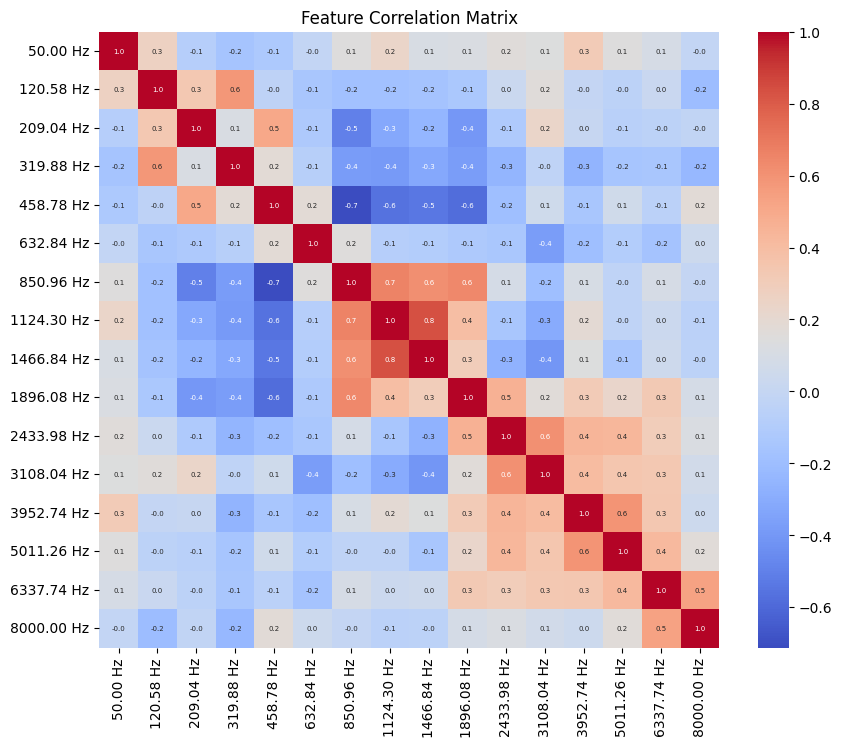

,Feature,VIF
0,50.00 Hz,2.764945
1,120.58 Hz,41.019661
2,209.04 Hz,30.227933
3,319.88 Hz,34.290703
4,458.78 Hz,24.242304
5,632.84 Hz,20.798270
6,850.96 Hz,25.037287
7,1124.30 Hz,16.435708
8,1466.84 Hz,14.184847
9,1896.08 Hz,10.626047


In [20]:
# # Check the multicolinearity and reduce the feature dimensions
check_multicollinearity(np.array(list(envelope_feature_dict.values())),
                        feature_names)

In [ ]:
# PCA
print("\n--- Running PCA with automatic component selection (95% variance) ---")
pca_results_auto, _, loadings_df = perform_pca_on_acoustic_features(
    envelope_feature_dict,original_feature_names=feature_names,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
sns.heatmap(loadings_df)
envelope_feature_dict_pca = pca_results_auto.to_dict('index')
envelope_feature_dict_pca = {key: list(value.values()) for key, value in envelope_feature_dict_pca.items()}

for key, values in list(envelope_feature_dict_pca.items())[:5]:  # Show first 5 entries
    print(key, ":", values)

In [ ]:
check_multicollinearity(np.array(list(envelope_feature_dict_pca.values())),
                        ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])

In [ ]:
# Save dictionary
import pickle
envelope_feature_dict_path = "envelope_feature_dict.pickle"
with open(envelope_feature_dict_path, 'wb') as handle:
    pickle.dump(envelope_feature_dict_pca, handle)

In [ ]:
envelope_feature_dict_pca = pd.DataFrame(envelope_feature_dict_pca)
num_rows = envelope_feature_dict_pca.shape[0]
envelope_feature_dict_pca.index = [f"aco{i+1}" for i in range(num_rows)]
print(envelope_feature_dict_pca)
envelope_feature_dict_pca.to_csv(os.path.join(lme_dir,'envelope_feature_dict_pca.csv'), index=True)

## 3. Acoustic+Phonemeic feature (for a whole token)


In [ ]:
def classify_pca(loadings_df, ratio_threshold=6/4):
    hz_cols = [col for col in loadings_df.columns if 'Hz' in col]
    other_cols = [col for col in loadings_df.columns if 'Hz' not in col]
    
    if len(hz_cols) == 0 or len(other_cols) == 0:
        raise ValueError("Loadings DataFrame must contain at least one 'Hz' feature column and one non-'Hz' feature column.")

    pc_new_names = {}
    
    aco_counter = 1
    pho_counter = 1
    acpho_counter = 1

    for pc_idx, row in loadings_df.iterrows():
        aco_w = np.mean(np.abs(row[hz_cols]))
        pho_w = np.mean(np.abs(row[other_cols]))

        if pho_w / aco_w > ratio_threshold:
            new_name = f'pho{pho_counter}'
            pho_counter += 1
        elif aco_w / pho_w > ratio_threshold:
            new_name = f'aco{aco_counter}'
            aco_counter += 1
        else:
            new_name = f'mix{acpho_counter}'
            acpho_counter += 1
            
        pc_new_names[pc_idx] = new_name
    
    return pc_new_names

In [ ]:
# Load dictionary of HG responses and make a lexical status mapping
HOME = os.path.expanduser("~")
LAB_root = os.path.join(HOME, "Box", "CoganLab")

stats_root_delay = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "stats")
stats_root_nodelay = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepNoDelay', 'BIDS', "derivatives", "stats")

epoc_LexDelayRep_Aud,_=gp.load_stats('zscore','Auditory_inRep','epo',stats_root_delay,stats_root_delay,keeptrials=True,testsubj=True)

stim_lexsts = epoc_LexDelayRep_Aud.labels[0].split('/')[:,[3,2]]
del epoc_LexDelayRep_Aud
lexsts_dict = {str(item[0].split('-')[0]): str(item[1]) for item in stim_lexsts}
lexsts_bi_dict = {key: [1] if value == 'Word' else [0] for key, value in lexsts_dict.items()}
lexsts_bi_dict['magic']=[1]
print(lexsts_bi_dict)

In [ ]:
aco_pho_lex_dict = {key: lexsts_bi_dict[key] + envelope_feature_dict[key] + phoneme_one_hot_dict_filt[key].tolist()  for key in envelope_feature_dict}
check_multicollinearity(np.array(list(aco_pho_lex_dict.values())),
                        ['lex']+feature_names+all_phonemes_filt)

In [ ]:
pca_results_aco_pho, _, loadings_df = perform_pca_on_acoustic_features(
    aco_pho_lex_dict,original_feature_names=['lex']+feature_names+all_phonemes_filt,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
aco_pho_dict_pca = pca_results_aco_pho.to_dict('index')
aco_pho_dict_dict_pca = {key: list(value.values()) for key, value in aco_pho_dict_pca.items()}

In [ ]:
aco_pho_dict_pca_df = pd.DataFrame(aco_pho_dict_pca)
print(aco_pho_dict_pca_df)
pc_new_names=classify_pca(loadings_df,ratio_threshold=6/4)
aco_pho_dict_pca_df.rename(index=pc_new_names, inplace=True)
print(aco_pho_dict_pca_df)
sns.heatmap(loadings_df.rename(index=pc_new_names))
print(loadings_df.T)
aco_pho_dict_pca_df.to_csv(os.path.join(lme_dir,'aco_pho_dict_pca.csv'), index=True)

## 4. Acoustic+Phonemeic feature (pho1 or 2 only)


In [ ]:
pho=2

In [ ]:
# Get acoustic features
phoX_aco_dict = {}
with open(f"envelope_power_bins_pho{pho}.txt", "r") as file:
    for line in file:
        parts = line.strip().split("\t")
        key = parts[0]
        values = list(map(float, parts[1:]))  # Convert remaining columns to float
        phoX_aco_dict[key] = values
feature_names=['50.00 Hz','120.58 Hz','209.04 Hz','319.88 Hz','458.78 Hz','632.84 Hz','850.96 Hz','1124.30 Hz','1466.84 Hz','1896.08 Hz','2433.98 Hz','3108.04 Hz','3952.74 Hz','5011.26 Hz','6337.74 Hz','8000.00 Hz']
# Print a sample of the dictionary
for key, values in list(phoX_aco_dict.items())[:5]:  # Show first 5 entries
    print(key, ":", values)
check_multicollinearity(np.array(list(phoX_aco_dict.values())),
                        feature_names)

In [ ]:
# Get phoneme vector for phoX
all_phonemes_phoX = set()
for phonemes in syllables.values():
    all_phonemes_phoX.add(phonemes[pho-1])
print(all_phonemes_phoX)
all_phonemes_phoX = sorted(list(all_phonemes_phoX))  # Sort for consistent ordering
phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(all_phonemes_phoX)}
vector_length = len(all_phonemes_phoX)

# Create one-hot encoding for each word (only pho1)
phoX_pho_dict = {}
for word, phonemes in syllables.items():
    # Initialize vector with zeros
    vector = [0] * vector_length
    # Set 1 for each phoneme present in the word
    vector[phoneme_to_index[phonemes[pho-1]]] = 1
    phoX_pho_dict[word] = vector

check_multicollinearity(np.array(list(phoX_pho_dict.values())),
                        all_phonemes_phoX)

In [ ]:
# Combine the two and run PCA
phoX_aco_pho_dict = {key: phoX_aco_dict[key] + phoX_pho_dict[key]
                    for key in phoX_aco_dict}
check_multicollinearity(np.array(list(phoX_aco_pho_dict.values())),
                        feature_names+all_phonemes_phoX)
phoX_aco_pho_dict_pca_df, _, loadings_df = perform_pca_on_acoustic_features(
    phoX_aco_pho_dict,original_feature_names=feature_names+all_phonemes_phoX,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
print(loadings_df)
phoX_aco_pho_dict_pca_df=phoX_aco_pho_dict_pca_df.T
print(phoX_aco_pho_dict_pca_df)
pc_new_names=classify_pca(loadings_df,ratio_threshold=6/4)
phoX_aco_pho_dict_pca_df.rename(index=pc_new_names, inplace=True)
print(phoX_aco_pho_dict_pca_df)
loadings_df=np.abs(loadings_df)
sns.heatmap(loadings_df.rename(index=pc_new_names))
phoX_aco_pho_dict_pca_df.to_csv(os.path.join(lme_dir,f'pho{pho}_aco_pho_dict_pca.csv'), index=True)


## 5. Acoustic+Phonemeic feature (syllable1 only)


In [ ]:
# Get acoustic features
syl1_aco_dict = {}
with open("envelope_power_bins_syl1.txt", "r") as file:
    for line in file:
        parts = line.strip().split("\t")
        key = parts[0]
        values = list(map(float, parts[1:]))  # Convert remaining columns to float
        syl1_aco_dict[key] = values
feature_names=['50.00 Hz','120.58 Hz','209.04 Hz','319.88 Hz','458.78 Hz','632.84 Hz','850.96 Hz','1124.30 Hz','1466.84 Hz','1896.08 Hz','2433.98 Hz','3108.04 Hz','3952.74 Hz','5011.26 Hz','6337.74 Hz','8000.00 Hz']
# Print a sample of the dictionary
for key, values in list(syl1_aco_dict.items())[:5]:  # Show first 5 entries
    print(key, ":", values)
check_multicollinearity(np.array(list(syl1_aco_dict.values())),
                        feature_names)

In [ ]:
# Get phoneme vector for pho1
all_phonemes_syl1 = set()
for phonemes in syllables.values():
    all_phonemes_syl1.add(phonemes[0])
    all_phonemes_syl1.add(phonemes[1])
all_phonemes_syl1 = sorted(list(all_phonemes_syl1))  # Sort for consistent ordering
phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(all_phonemes_syl1)}
vector_length = len(all_phonemes_syl1)

# Create one-hot encoding for each word (only pho1)
syl1_pho_dict = {}
for word, phonemes in syllables.items():
    # Initialize vector with zeros
    vector = [0] * vector_length
    # Set 1 for each phoneme present in the word
    vector[phoneme_to_index[phonemes[0]]] = 1
    vector[phoneme_to_index[phonemes[1]]] = 1
    syl1_pho_dict[word] = vector

check_multicollinearity(np.array(list(syl1_pho_dict.values())),
                        all_phonemes_syl1)

In [ ]:
# Combine the two and run PCA
syl1_aco_pho_dict = {key: syl1_aco_dict[key] + syl1_pho_dict[key]
                    for key in syl1_aco_dict}
check_multicollinearity(np.array(list(syl1_aco_pho_dict.values())),
                        feature_names+all_phonemes_syl1)
syl1_aco_pho_dict_pca_df, _, loadings_df = perform_pca_on_acoustic_features(
    syl1_aco_pho_dict,original_feature_names=feature_names+all_phonemes_syl1,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
print(loadings_df)
syl1_aco_pho_dict_pca_df=syl1_aco_pho_dict_pca_df.T
print(syl1_aco_pho_dict_pca_df)
pc_new_names=classify_pca(loadings_df,ratio_threshold=6/4)
syl1_aco_pho_dict_pca_df.rename(index=pc_new_names, inplace=True)
print(syl1_aco_pho_dict_pca_df)
loadings_df=np.abs(loadings_df)
sns.heatmap(loadings_df.rename(index=pc_new_names))
syl1_aco_pho_dict_pca_df.to_csv(os.path.join(lme_dir,'syl1_aco_pho_dict_pca.csv'), index=True)

## 6. Transformer embedding


In [ ]:
from sentence_transformers import SentenceTransformer
words = list(syllables.keys())
print(words)
model = SentenceTransformer('all-MiniLM-L6-v2')
word_embeddings = model.encode(words)
word_to_embedding = {word: embedding for word, embedding in zip(words, word_embeddings)}

In [ ]:
print("valuk：",word_to_embedding['valuk'])

In [ ]:
embd_names=[str(i) for i in range(len(word_to_embedding['valuk']))]
check_multicollinearity(np.array(list(word_to_embedding.values())),embd_names)

In [ ]:
word_to_embedding_pca_df, _, loadings_df = perform_pca_on_acoustic_features(
    word_to_embedding,original_feature_names=embd_names,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)

In [ ]:
sns.heatmap(loadings_df)
embdpc_names= {f'PC{str(i)}':f'Wordvec{str(i)}' for i in range(word_to_embedding_pca_df.shape[1]+1)}

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

random_sample = word_to_embedding_pca_df.iloc[[0, 1, 5, 9, 10, 13, 14, 18, 19, 21]]
ax.scatter(random_sample['PC1'], random_sample['PC2'], random_sample['PC3'], c='blue', s=100)

for word, row in random_sample.iterrows():
    ax.text(row['PC1'], row['PC2'], row['PC3'], word, fontsize=12, zorder=1)

ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_zlabel('PC3', fontsize=10)


In [ ]:

word_to_embedding_pca_df=word_to_embedding_pca_df.T
print(word_to_embedding_pca_df)
word_to_embedding_pca_df.rename(index=embdpc_names,inplace=True)
word_to_embedding_pca_df.to_csv(os.path.join(lme_dir,'word_to_embedding_pca.csv'), index=True)
